This is pulled from https://github.com/snap-stanford/ogb/tree/master/examples/lsc/pcqm4m

dependencies:
- install rdkit (I used conda) https://www.rdkit.org/docs/Install.html
1. conda create -c conda-forge -n my-rdkit-env rdkit
2. conda activate my-rdkit-env
3. cd [anaconda folder]/bin
4. source activate my-rdkit-env

- install ogb, torch and pytorch-geometric

- run the main-gnn.py code to download the dataset, extract and train (see the readme.md). I could finish extracting because my RAM wasn't enough. If you face the some problem, use this notebook to extract just a handful of the dataset. This code is taken from 

In [1]:
from ogb.lsc import DglPCQM4MDataset, PCQM4MEvaluator

import argparse
import dgl
import numpy as np
import os
import random
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

import pandas as pd

from gnn import GNN

import os
import os.path as osp
import shutil
from ogb.utils import smiles2graph
from ogb.utils.torch_util import replace_numpy_with_torchtensor
from ogb.utils.url import decide_download, download_url, extract_zip
import pandas as pd
import numpy as np
from dgl.data.utils import load_graphs, save_graphs, Subset
import dgl
from tqdm import tqdm
import torch

reg_criterion = torch.nn.L1Loss()

Using backend: pytorch


In [2]:
# !mkdir log
# !mkdir checkpoint
# !mkdir test

In [3]:
# !python main_gnn.py --gnn gcn --log_dir log --checkpoint_dir checkpoint --save_test_dir test

In [4]:
"""
my folder structure looks like (obtained from running main_gnn)
dataset/
    pcqm4m_kddcup2021/
        mapping/
        processed/
        raw/
            data.csv.gz
"""

ROOT = "dataset/pcqm4m_kddcup2021"
filename = "{}/{}".format(ROOT, "raw/data.csv.gz")
data_df = pd.read_csv(filename)
data_df

,idx,smiles,homolumogap
0,0,Cc1ccc(cc1)C1C=c2cnccc2=NC1=O,3.047675
1,1,COc1cc(OC)ccc1C=CN(C(=O)C)C,4.410966
2,2,C=CCN(C(=O)C)C=Cc1ccccc1C,4.639541
3,3,C=CCN(C(=O)C)C=Cc1ccccc1F,4.492600
4,4,C=CCN(C(=O)C)C=Cc1ccccc1Cl,4.612330
...,...,...,...
3803448,3803448,O=N(=O)c1ccc(c(c1)N(=O)=O)Cl,NaN
3803449,3803449,NCC(=O)COP(=O)(O)O,NaN
3803450,3803450,CC(CN)O,NaN
3803451,3803451,OC1C=CC=C(C1O)C(=O)O,NaN


In [5]:
"""
Load Train/Test/Valid split dictionary
"""
# INPUT PARAMETERS HERE: SET TRAIN, TEST AND VAL SIZE
trainSize = 50000
testSize = 10000
valSize = 10000

# load raw split dict
split_dict = torch.load(osp.join(ROOT, 'split_dict.pt'))
# load new split dict
new_split_dict = split_dict.copy()

# sample new split dict
new_split_dict["train"] = np.random.choice(new_split_dict["train"], size=trainSize, replace=False)
new_split_dict["test"] = np.random.choice(new_split_dict["test"], size=testSize, replace=False)
new_split_dict["valid"] = np.random.choice(new_split_dict["valid"], size=valSize, replace=False)

In [6]:
# extract train, test and valid indices
sampleIndices = np.append(
    new_split_dict["train"], [new_split_dict["test"], new_split_dict["valid"]]
)

# remap indices
idMapping = {}
for i, index in enumerate(sampleIndices):
    idMapping[index] = i
    
# idMapping

In [7]:
"""
Save New Dataframe based on smaller samples
"""
# filter dataframe
sampleDF = data_df.iloc[sampleIndices]
sampleDF["old_idx"] = sampleDF["idx"]
# remap the index
sampleDF["idx"] = sampleDF["idx"].apply(lambda x: idMapping[x])
sampleDF.index = sampleDF["idx"]

# save sample dataframe
sampleDF.to_csv(osp.join(ROOT, "raw", "sample_data.csv.gz"))

sampleDF

C:\Users\eek31\AppData\Local\Continuum\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\eek31\AppData\Local\Continuum\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,idx,smiles,homolumogap,old_idx
idx,,,,
0,0,ONC(=N)Nc1cccnc1,4.895328,1292294
1,1,CCNC(c1cccc(c1)C)C#C,5.899428,700579
2,2,CCN(C(=O)C)CCC(=N)S,6.713049,1488949
3,3,CCO[C@H](C(CC)(CC)O)C(C)C,8.413760,1666724
4,4,CN(C(=O)C(=O)O)CCCC,5.834121,2483664
...,...,...,...,...
69995,69995,CCNC/C=C/C(C)(C)C,6.533454,3206920
69996,69996,Cc1ccc(cc1)OC1=NCCS1,5.991947,3149201
69997,69997,CCSSc1ccc(cc1)C,5.012337,3191308


In [8]:
"""
Remap split_dict indices
"""
new_split_dict["train"] = np.array([idMapping[x] for x in new_split_dict["train"]])
new_split_dict["test"] = np.array([idMapping[x] for x in new_split_dict["test"]])
new_split_dict["valid"] = np.array([idMapping[x] for x in new_split_dict["valid"]])

torch.save(new_split_dict, osp.join(ROOT, "sample_split_dict.pt"))

## load data

In [9]:
def collate_dgl(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.stack(labels)

    return batched_graph, labels

In [10]:
from ogb.lsc import DglPCQM4MDataset, PCQM4MEvaluator

class SampleDglPCQM4MDataset(DglPCQM4MDataset):
    
    @property
    def raw_file_names(self):
        return 'sample_data.csv.gz'

    def prepare_graph(self):
        processed_dir = osp.join(self.folder, 'processed')
        raw_dir = osp.join(self.folder, 'raw')
        pre_processed_file_path = osp.join(processed_dir, 'dgl_data_processed')

        if osp.exists(pre_processed_file_path):        
            # if pre-processed file already exists
            self.graphs, label_dict = load_graphs(pre_processed_file_path)
            self.labels = label_dict['labels']
        else:
            # if pre-processed file does not exist
            
            if not osp.exists(osp.join(raw_dir, 'sample_data.csv.gz')):
                # if the raw file does not exist, then download it.
                self.download()

            data_df = pd.read_csv(osp.join(raw_dir, 'sample_data.csv.gz'))
            smiles_list = data_df['smiles']
            homolumogap_list = data_df['homolumogap']

            print('Converting SMILES strings into graphs...')
            self.graphs = []
            self.labels = []
            for i in tqdm(range(len(smiles_list))):

                smiles = smiles_list[i]
                homolumogap = homolumogap_list[i]
                graph = self.smiles2graph(smiles)
                
                assert(len(graph['edge_feat']) == graph['edge_index'].shape[1])
                assert(len(graph['node_feat']) == graph['num_nodes'])

                dgl_graph = dgl.graph((graph['edge_index'][0], graph['edge_index'][1]), num_nodes = graph['num_nodes'])
                dgl_graph.edata['feat'] = torch.from_numpy(graph['edge_feat']).to(torch.int64)
                dgl_graph.ndata['feat'] = torch.from_numpy(graph['node_feat']).to(torch.int64)

                self.graphs.append(dgl_graph)
                self.labels.append(homolumogap)

            self.labels = torch.tensor(self.labels, dtype=torch.float32)

            # double-check prediction target
            split_dict = self.get_idx_split()
            assert(all([not torch.isnan(self.labels[i]) for i in split_dict['train']]))
            assert(all([not torch.isnan(self.labels[i]) for i in split_dict['valid']]))
            assert(all([torch.isnan(self.labels[i]) for i in split_dict['test']]))

            print('Saving...')
            save_graphs(pre_processed_file_path, self.graphs, labels={'labels': self.labels})
        
    
    # just modify the get_idx_split function to call our new filename
    def get_idx_split(self):
        # NOTE: CHANGED split_dict.pt to sample_split_dict.pt
        split_dict = replace_numpy_with_torchtensor(torch.load(osp.join(self.folder, 'sample_split_dict.pt')))
        return split_dict

In [11]:
isSample = True #False #

if isSample:
    dataset = SampleDglPCQM4MDataset(root = 'dataset/')
else:
#     !rm dataset/pcqm4m_kddcup2021/processed/geometric_data_processed.pt
    dataset = DglPCQM4MDataset(root = 'dataset/')

In [12]:
split_idx = dataset.get_idx_split()
split_idx["train"] = split_idx["train"].type(torch.LongTensor)
split_idx["test"] = split_idx["test"].type(torch.LongTensor)
split_idx["valid"] = split_idx["valid"].type(torch.LongTensor)

split_idx["train"], split_idx["test"], split_idx["valid"]

(tensor([    0,     1,     2,  ..., 49997, 49998, 49999]),
 tensor([50000, 50001, 50002,  ..., 59997, 59998, 59999]),
 tensor([60000, 60001, 60002,  ..., 69997, 69998, 69999]))

In [13]:
evaluator = PCQM4MEvaluator()

In [14]:
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "checkpoint"
args.device = 0
args.log_dir = "models/gin-virtual/log"
args.checkpoint_dir = "models/gin-virtual/checkpoint"
args.train_subset = False
args.epochs = 1
args.save_test_dir = "models/gin-virtual/test"

In [15]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [16]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers, collate_fn=collate_dgl)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers, collate_fn=collate_dgl)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers, collate_fn=collate_dgl)

In [17]:
shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


## default model

In [18]:
from gnn import GNN

In [19]:
model = GNN(gnn_type='gin', virtual_node=True, **shared_params).to(device)

In [20]:
# check if checkpoint exist -> load model
checkpointFile = os.path.join(args.checkpoint_dir, 'checkpoint.pt')
if os.path.exists(checkpointFile):
    # load weights
    print("Loading existing weights from {}".format(checkpointFile))
    checkpointData = torch.load(checkpointFile)
    model.load_state_dict(checkpointData["model_state_dict"])

Loading existing weights from models/gin-virtual/checkpoint\checkpoint.pt


In [21]:
from main import train, eval, test

In [22]:
num_params = sum(p.numel() for p in model.parameters())
print(f'#Params: {num_params}')

optimizer = optim.Adam(model.parameters(), lr=0.001)

if args.log_dir is not '':
    writer = SummaryWriter(log_dir=args.log_dir)

best_valid_mae = 1000

if args.train_subset:
    scheduler = StepLR(optimizer, step_size=300, gamma=0.25)
    args.epochs = 1000
else:
    scheduler = StepLR(optimizer, step_size=30, gamma=0.25)

for epoch in range(1, args.epochs + 1):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train_mae = train(model, device, train_loader, optimizer)

    print('Evaluating...')
    valid_mae = eval(model, device, valid_loader, evaluator)

    print({'Train': train_mae, 'Validation': valid_mae})

    if args.log_dir is not '':
        writer.add_scalar('valid/mae', valid_mae, epoch)
        writer.add_scalar('train/mae', train_mae, epoch)

    if valid_mae < best_valid_mae:
        best_valid_mae = valid_mae
        if args.checkpoint_dir is not '':
            print('Saving checkpoint...')
            checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler_state_dict': scheduler.state_dict(), 'best_val_mae': best_valid_mae,
                          'num_params': num_params}
            torch.save(checkpoint, os.path.join(args.checkpoint_dir, 'checkpoint.pt'))

        if args.save_test_dir is not '':
            print('Predicting on test data...')
            y_pred = test(model, device, test_loader)
#             print('Saving test submission file...')
#             evaluator.save_test_submission({'y_pred': y_pred}, args.save_test_dir)

    scheduler.step()

    print(f'Best validation MAE so far: {best_valid_mae}')

Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

#Params: 6656406
=====Epoch 1
Training...


Iteration:   5%|███▌                                                                    | 2/40 [00:00<00:03, 12.50it/s]

Evaluating...


Iteration: 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.74it/s]


{'Train': 0.3605065948652978, 'Validation': 0.3968515396118164}
Saving checkpoint...


Iteration:   5%|███▌                                                                    | 2/40 [00:00<00:03, 12.05it/s]

Predicting on test data...


Iteration: 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.97it/s]

Best validation MAE so far: 0.3968515396118164


## DiffPool

In [23]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import numpy as np
from scipy.linalg import block_diag

import dgl

from model.dgl_layers import GraphSage, GraphSageLayer, DiffPoolBatchedGraphLayer
from model.tensorized_layers import *
from model.model_utils import batch2tensor
import time

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.linalg import block_diag

import dgl.function as fn

from model.dgl_layers.aggregator import MaxPoolAggregator, MeanAggregator, LSTMAggregator
from model.dgl_layers.bundler import Bundler
from model.model_utils import masked_softmax
from model.loss import EntropyLoss


In [25]:
class GraphSageLayer(nn.Module):
    """
    GraphSage layer in Inductive learning paper by hamilton
    Here, graphsage layer is a reduced function in DGL framework
    """

    def __init__(self, in_feats, out_feats, activation, dropout,
                 aggregator_type, bn=False, bias=True):
        super(GraphSageLayer, self).__init__()
        self.use_bn = bn
        self.bundler = Bundler(in_feats, out_feats, activation, dropout,
                               bias=bias)
        self.dropout = nn.Dropout(p=dropout)

        if aggregator_type == "maxpool":
            self.aggregator = MaxPoolAggregator(in_feats, in_feats,
                                                activation, bias)
        elif aggregator_type == "lstm":
            self.aggregator = LSTMAggregator(in_feats, in_feats)
        else:
            self.aggregator = MeanAggregator()

    # edge_attr not used
    def forward(self, g, h):
        h = self.dropout(h)
        g.ndata['h'] = h
        if self.use_bn and not hasattr(self, 'bn'):
            device = h.device
            self.bn = nn.BatchNorm1d(h.size()[1]).to(device)
        g.update_all(fn.copy_src(src='h', out='m'), self.aggregator,
                     self.bundler)
        if self.use_bn:
            h = self.bn(h)
        h = g.ndata.pop('h')
        return h

In [26]:
class DiffPoolBatchedGraphLayer(nn.Module):

    def __init__(self, input_dim, assign_dim, output_feat_dim,
                 activation, dropout, aggregator_type, link_pred):
        super(DiffPoolBatchedGraphLayer, self).__init__()
        self.embedding_dim = input_dim
        self.assign_dim = assign_dim
        self.hidden_dim = output_feat_dim
        self.link_pred = link_pred
        
        self.feat_gc = GraphSageLayer(
            input_dim,
            output_feat_dim,
            activation,
            dropout,
            aggregator_type)

        self.pool_gc = GraphSageLayer(
            input_dim,
            assign_dim,
            activation,
            dropout,
            aggregator_type)
        
        self.reg_loss = nn.ModuleList([])
        self.loss_log = {}
        self.reg_loss.append(EntropyLoss())

    def forward(self, g, h):
#         print("DiffPoolBatchedGraphLayer forward")
        feat = self.feat_gc(g, h)  # size = (sum_N, F_out), sum_N is num of nodes in this batch
#         print(feat.shape)
        device = feat.device
        assign_tensor = self.pool_gc(g, h)  # size = (sum_N, N_a), N_a is num of nodes in pooled graph.
        assign_tensor = F.softmax(assign_tensor, dim=1)
        assign_tensor = torch.split(assign_tensor, g.batch_num_nodes().tolist())
        assign_tensor = torch.block_diag(*assign_tensor)  # size = (sum_N, batch_size * N_a)

        h = torch.matmul(torch.t(assign_tensor), feat)
        adj = g.adjacency_matrix(transpose=False, ctx=device)
        adj_new = torch.sparse.mm(adj, assign_tensor)
        adj_new = torch.mm(torch.t(assign_tensor), adj_new)

        if self.link_pred:
            current_lp_loss = torch.norm(adj.to_dense() -
                                         torch.mm(assign_tensor, torch.t(assign_tensor))) / np.power(g.number_of_nodes(), 2)
            self.loss_log['LinkPredLoss'] = current_lp_loss

        for loss_layer in self.reg_loss:
            loss_name = str(type(loss_layer).__name__)
            self.loss_log[loss_name] = loss_layer(adj, adj_new, assign_tensor)

        return adj_new, h

In [27]:
first_diffpool_layer = DiffPoolBatchedGraphLayer(
    input_dim=600, # graph embedding dimension
    assign_dim=5, # group to 10
    output_feat_dim=600,
    activation=F.relu,
    dropout=0.0,
    aggregator_type="meanpool",
    link_pred=False
).to(device)

gc_after_pool = BatchedGraphSAGE(600, 600).to(device)

In [28]:
import torch
import torch.nn as nn

from dgl.nn.pytorch import SumPooling, AvgPooling, MaxPooling, GlobalAttentionPooling, Set2Set

from conv import GNN_node, GNN_node_Virtualnode

from gnn import GNN

class DiffPoolGNN(GNN):
    def __init__(self, num_tasks = 1, num_layers = 5, emb_dim = 300, gnn_type = 'gin',
                 virtual_node = True, residual = False, drop_ratio = 0, JK = "last",
                 graph_pooling = "sum"):
        super(DiffPoolGNN, self).__init__(num_tasks, num_layers, emb_dim, gnn_type,
                 virtual_node, residual, drop_ratio, JK, graph_pooling)
        
        # 2x number of outputs
        self.graph_pred_linear = nn.Linear(2*self.emb_dim, self.num_tasks)
#         self.graph_pred_linear = nn.Linear(self.emb_dim, self.num_tasks)

    def forward(self, g, x, edge_attr):
        # 1. GCN: 3628x9 -> 3628x600
        g.ndata['h'] = x
        h_node = self.gnn_node(g, x, edge_attr)
#         print(h_node.shape)

        # 2. Graph Pooling 256x600
        h_graph_1 = self.pool(g, h_node)
#         print(h_graph.shape)
        
        # 3. DiffPool: (1280x1280), (1280x600)
        adj, h_node = first_diffpool_layer(g, h_node)
#         print(adj.shape, h_node.shape)
        
        # 3b. split to batches
        node_per_pool_graph = int(adj.size()[0] / len(g.batch_num_nodes()))
        h_node, adj = batch2tensor(adj, h_node, node_per_pool_graph)
#         print(adj.shape, h_node.shape)

        # 4. GCN:
        h_node = self.gcn_forward_tensorized(h_node, adj, [gc_after_pool], True)
#         print(h_node.shape)

        # 5. Graph Pooling 256x600
        h_graph_2 = torch.sum(h_node, dim=1)
#         print("h_graph_2", h_graph_2.shape)

        # 6. Last Layer; Combine Graph Embeddings
#         print(h_graph_1.shape, h_graph_2.shape)
        h_graph = torch.cat([h_graph_1, h_graph_2], dim=1)
#         h_graph = h_graph_1

        output = self.graph_pred_linear(h_graph)
#         print("output", output.shape)

        if self.training:
            return output
        else:
            return torch.clamp(output, min=0, max=50)

    def gcn_forward_tensorized(self, h, adj, gc_layers, cat=False):
        block_readout = []
        for gc_layer in gc_layers:
            h = gc_layer(h, adj)
            block_readout.append(h)
        if cat:
            block = torch.cat(block_readout, dim=2)  # N x F, F = F1 + F2 + ...
        else:
            block = h
        return block

In [29]:
model = DiffPoolGNN(gnn_type='gin', virtual_node=True, **shared_params).to(device)
model

DiffPoolGNN(
  (gnn_node): GNN_node_Virtualnode(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 600)
        (1): Embedding(4, 600)
        (2): Embedding(12, 600)
        (3): Embedding(12, 600)
        (4): Embedding(10, 600)
        (5): Embedding(6, 600)
        (6): Embedding(6, 600)
        (7): Embedding(2, 600)
        (8): Embedding(2, 600)
      )
    )
    (virtualnode_embedding): Embedding(1, 600)
    (convs): ModuleList(
      (0): GINConv(
        (mlp): Sequential(
          (0): Linear(in_features=600, out_features=600, bias=True)
          (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=600, out_features=600, bias=True)
        )
        (bond_encoder): BondEncoder(
          (bond_embedding_list): ModuleList(
            (0): Embedding(5, 600)
            (1): Embedding(6, 600)
            (2): Embedding(2, 600)
         

In [30]:
args.epochs = 100
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
# train_mae = train(model, device, train_loader, optimizer)

loader = train_loader

# train
model.train()

for epoch in range(1, args.epochs + 1):
    loss_accum = 0
    for step, (bg, labels) in enumerate(tqdm(loader, desc="Iteration")):
        bg = bg.to(device)
        x = bg.ndata.pop('feat').to(device)
        edge_attr = bg.edata.pop('feat').to(device)
        labels = labels.to(device)

        pred = model(bg, x, edge_attr).view(-1,)
        optimizer.zero_grad()
        loss = reg_criterion(pred, labels)
        loss.backward()
        optimizer.step()

        loss_accum += loss.detach().cpu().item()

    print(loss_accum / (step + 1))

Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

1.0100752981949825


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.5416966737533102


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.5029906566653933


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.47400402399350183


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.5460313366992133


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.4456788873185917


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.39672939829072174


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.46514552892470845


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.44564012255595653


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.35568046189692554


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.45006899702913905


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.423834639392337


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3668473480003221


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.37538690629358196


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3919102765467702


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3599063509276935


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3438925003366811


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3768987279309302


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.4140807558991471


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.4226302281022072


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3207121318852415


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3231715012569817


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.4221976784875198


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3322792830972039


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.32532358420442564


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.32478098806982136


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.36592540365396714


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3412483968600935


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3322928112228306


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3036525866815022


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2757267714002911


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3369676585556293


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.38318411777822337


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.359329134149819


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3127203565471026


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.32179785261348803


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3287192267574826


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.29484676630521306


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.43315289595297407


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.41564147508874233


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.38825855198867465


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3118722912456308


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3350550384849918


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.32793680312378065


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3201688617011722


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3312188056962831


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3488712728935845


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3362577373580057


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3106643764340148


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3480658858862458


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3713311140938681


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3308291775079406


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.36961174839917493


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3061829969591024


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3113526428992651


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2921632467483988


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3270548093987971


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.32047245392994006


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.28526339520301136


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2877900941791583


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.31290424212205165


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2611483866158797


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2575836955588691


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.24859861809076095


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2629634228592016


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.23868678152865294


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.36405270257774663


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.27866945925111675


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.30011636748605847


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.3397277240090224


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.27386358509562453


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2698661562587534


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2755874126997529


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.31426936897392177


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2517551170776085


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2662215172788318


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.27140218277975003


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.24876407100533954


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.30816218082089814


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2825955076485264


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.31768930817441066


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.28103954497040534


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2823043549243285


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.26381224203778775


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2753395017008392


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.26117578224868193


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2770491666635688


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2524566957537009


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.28617066912809197


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2675293306154864


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.24335472878752923


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.22525764842118537


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2283057175120529


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.23727125385586095


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2548580427407002


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2193745846803091


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.22704424716684282


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.24229720820273673


Iteration:   0%|                                                                               | 0/196 [00:00<?, ?it/s]

0.2335045081468261


Iteration: 100%|█████████████████████████████████████████████████████████████████████| 196/196 [01:29<00:00,  2.19it/s]

0.2322159583623312


## interpret localpooling node mappings

In [32]:
with torch.no_grad():
    g, x, edge_attr = bg, x, edge_attr
    g.ndata['h'] = x
    h_node = model.gnn_node(g, x, edge_attr)
#         print(h_node.shape)

    # 3. DiffPool: (1280x1280), (1280x600)
#     adj, h_node = first_diffpool_layer(g, h_node)    
    g, h = g, h_node
#         print("DiffPoolBatchedGraphLayer forward")
    feat = first_diffpool_layer.feat_gc(g, h)  # size = (sum_N, F_out), sum_N is num of nodes in this batch
#         print(feat.shape)
    device = feat.device
    assign_tensor = first_diffpool_layer.pool_gc(g, h)  # size = (sum_N, N_a), N_a is num of nodes in pooled graph.
    assign_tensor = F.softmax(assign_tensor, dim=1)
    assign_tensor = torch.split(assign_tensor, g.batch_num_nodes().tolist())
#     assign_tensor = torch.block_diag(*assign_tensor)  # size = (sum_N, batch_size * N_a)

    # fix to 5 nodes
#     node_per_pool_graph = int(adj.size()[0] / len(g.batch_num_nodes()))
#     h_node, adj = batch2tensor(adj, h_node, node_per_pool_graph)

In [38]:
# 106
g.batch_size

80

In [40]:
import networkx as nx
import matplotlib.pyplot as plt


0


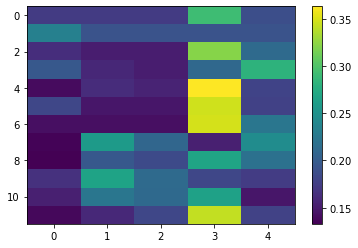

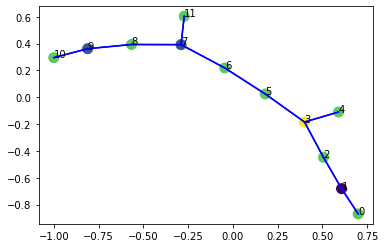

1


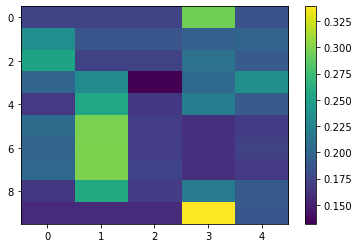

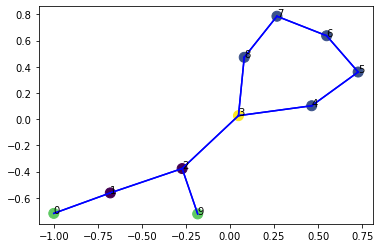

2


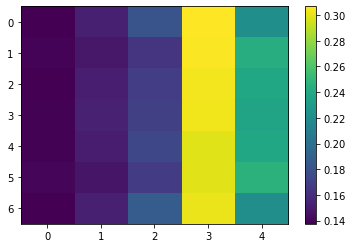

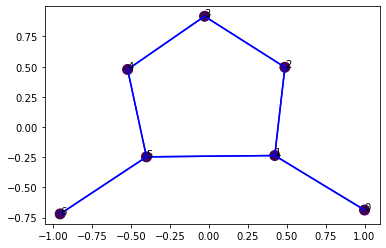

3


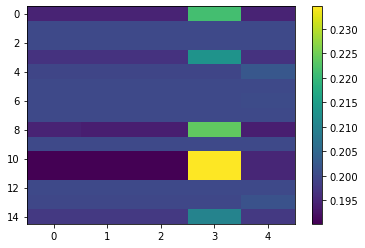

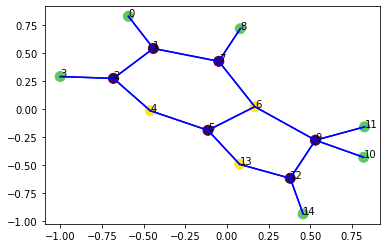

4


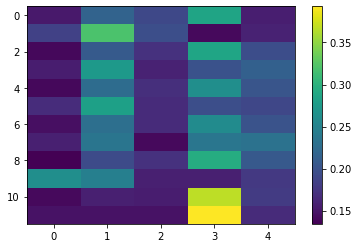

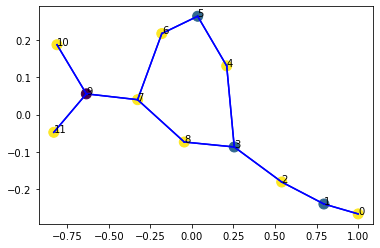

5


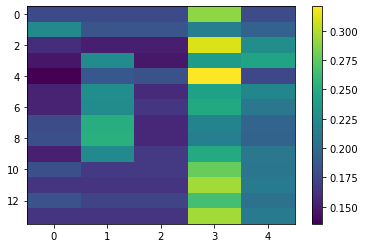

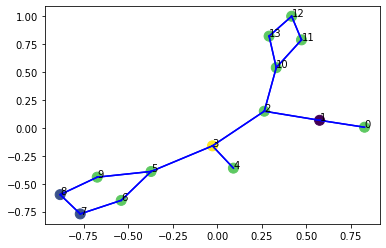

6


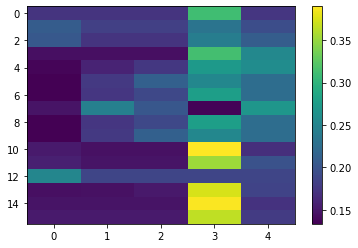

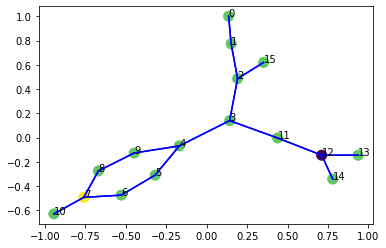

7


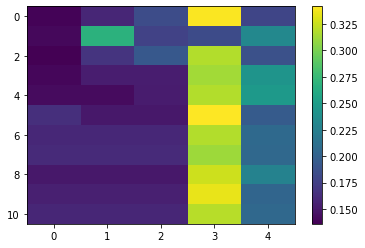

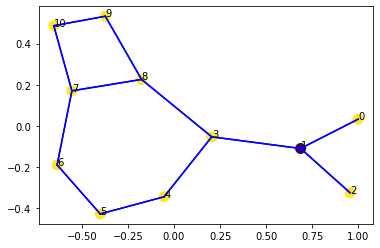

8


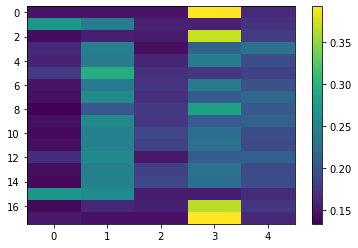

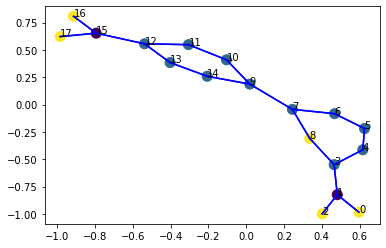

9


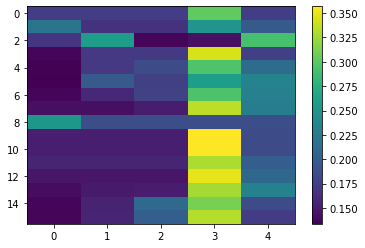

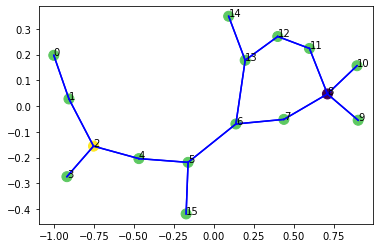

10


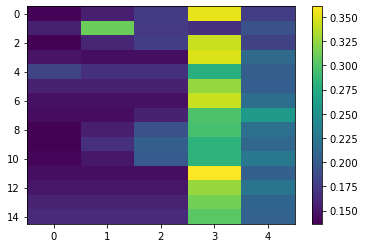

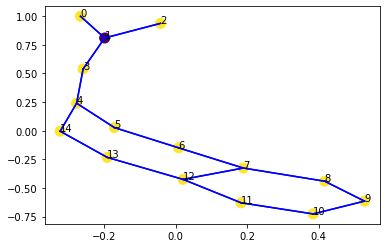

11


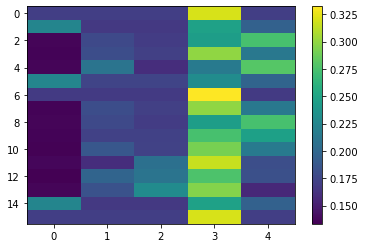

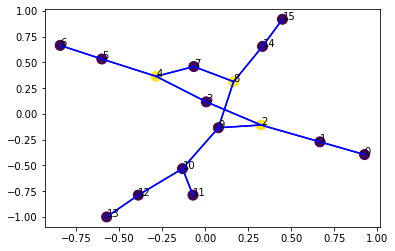

12


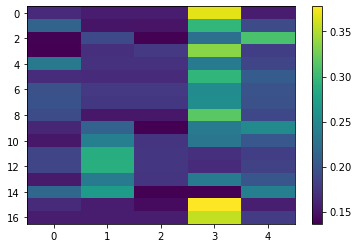

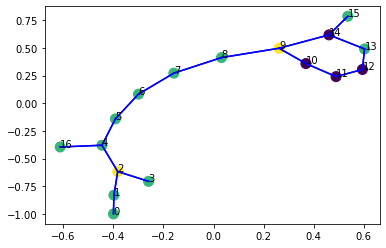

13


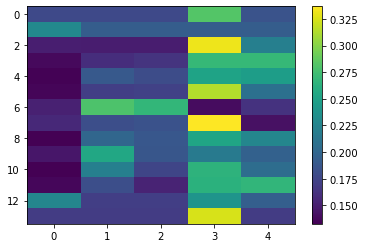

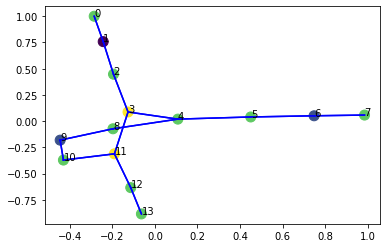

14


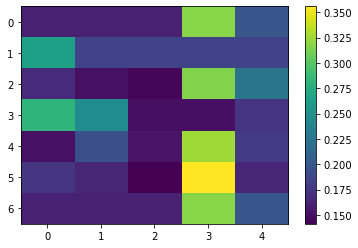

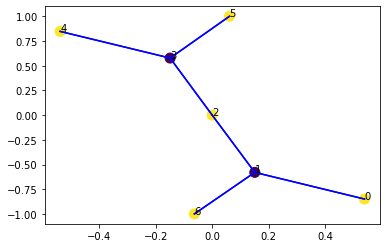

15


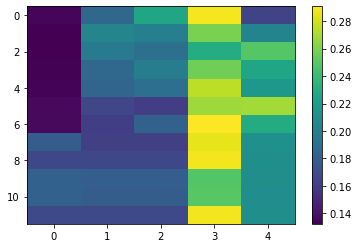

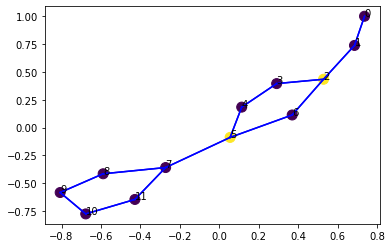

16


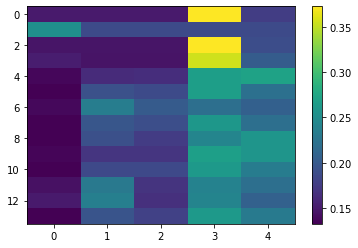

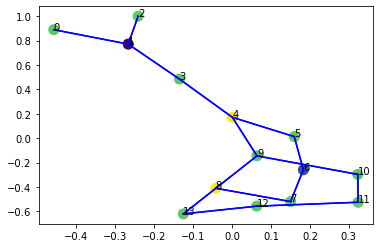

17


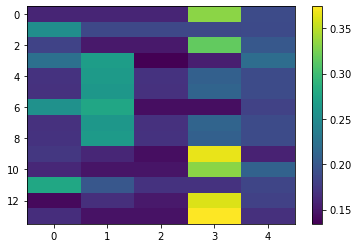

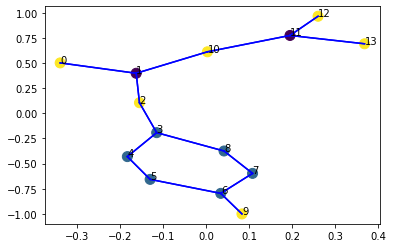

18


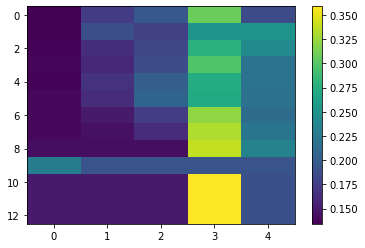

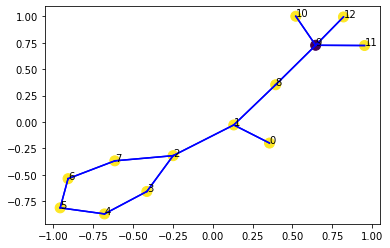

19


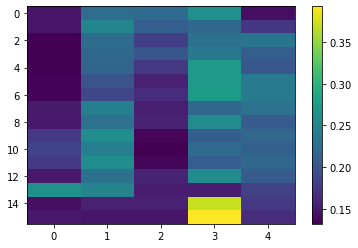

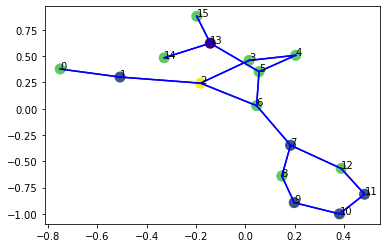

20


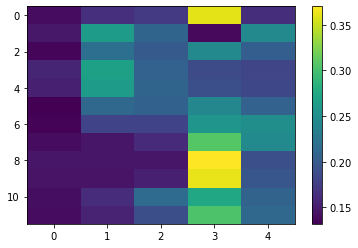

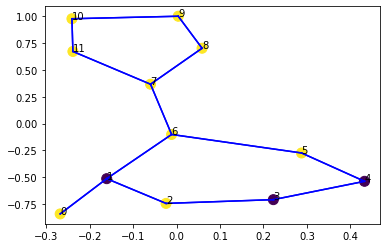

21


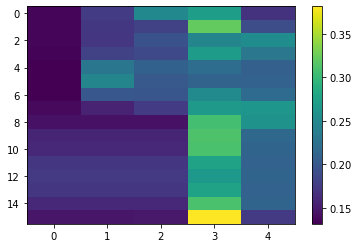

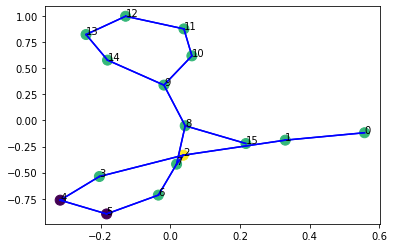

22


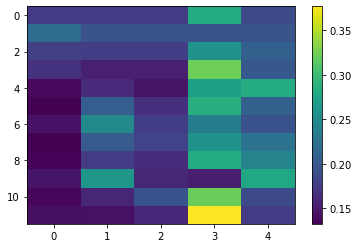

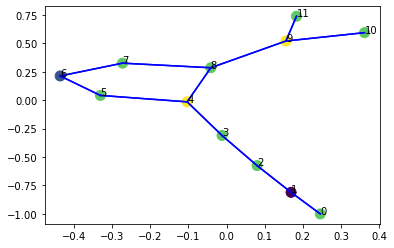

23


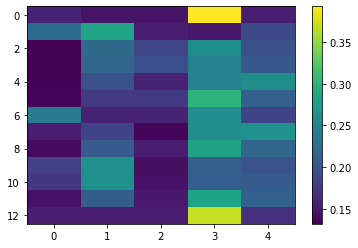

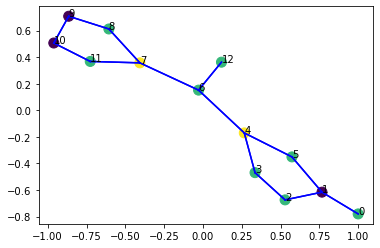

24


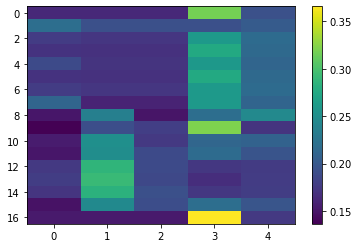

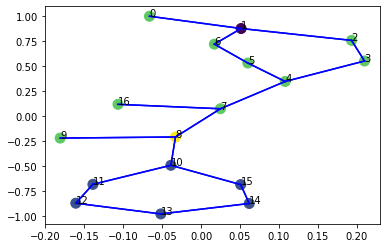

25


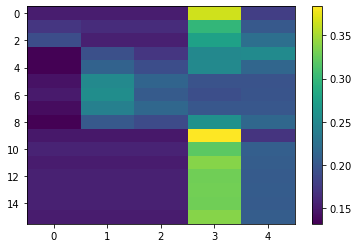

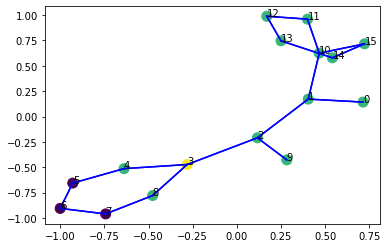

26


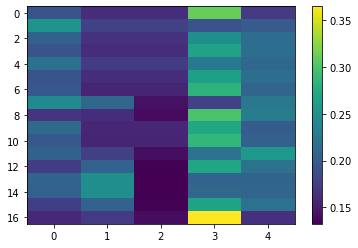

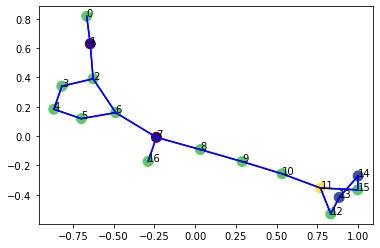

27


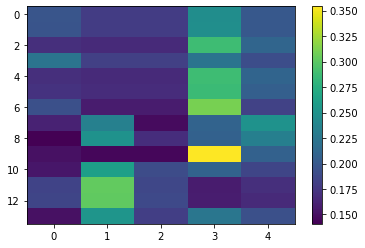

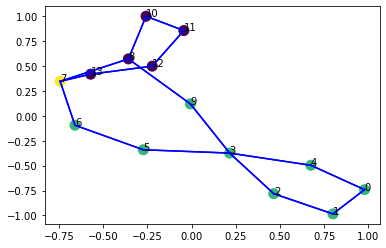

28


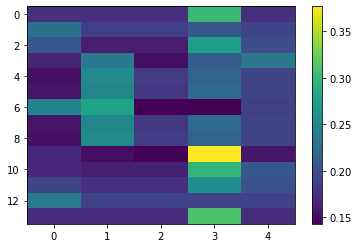

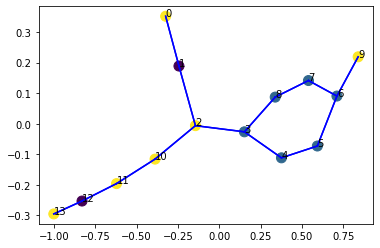

29


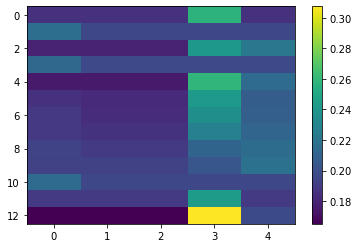

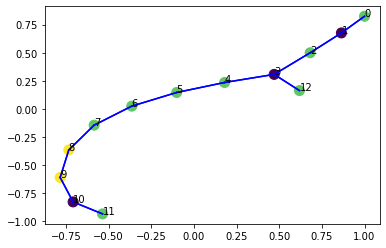

30


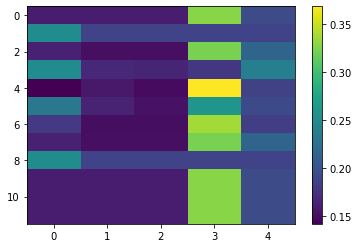

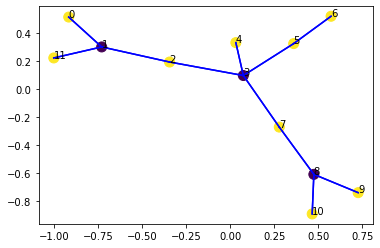

31


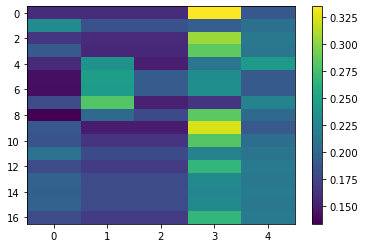

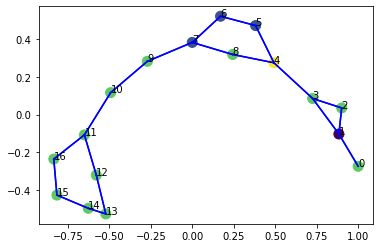

32


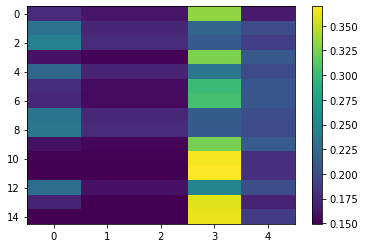

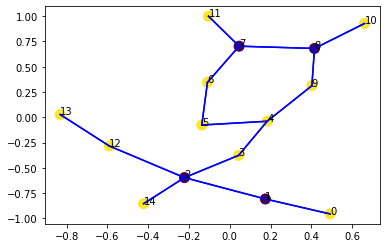

33


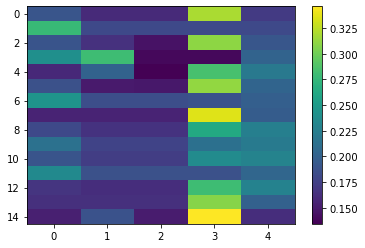

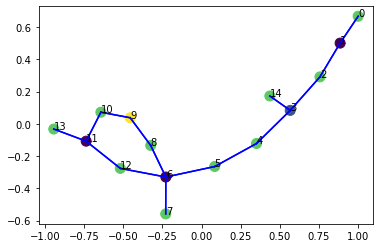

34


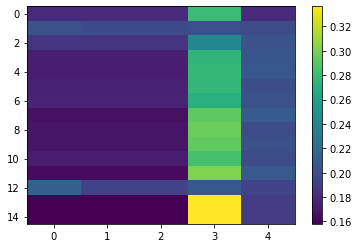

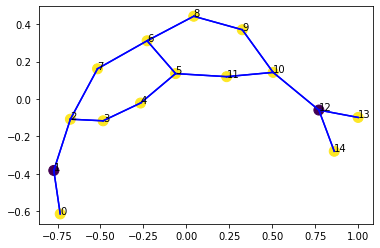

35


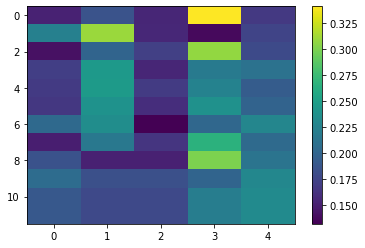

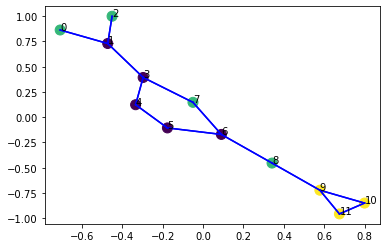

36


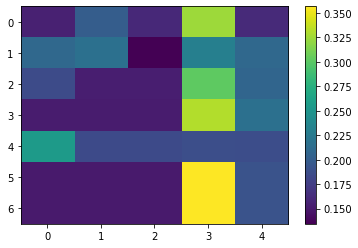

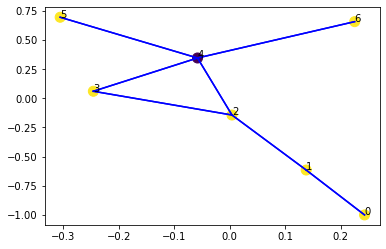

37


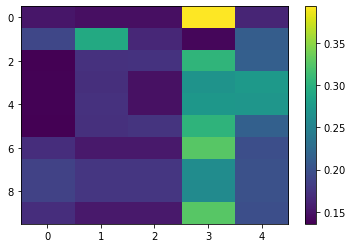

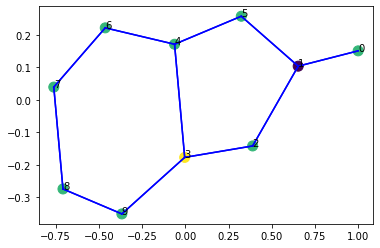

38


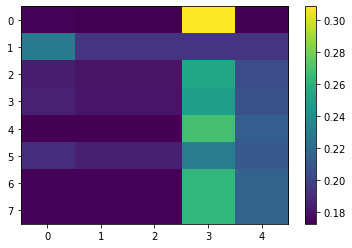

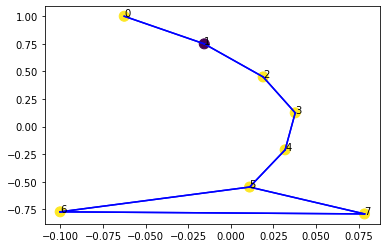

39


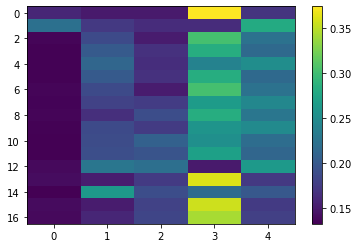

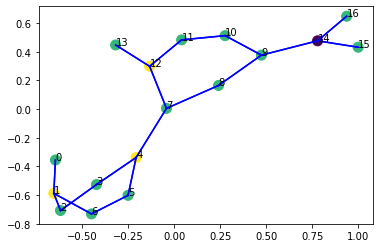

40


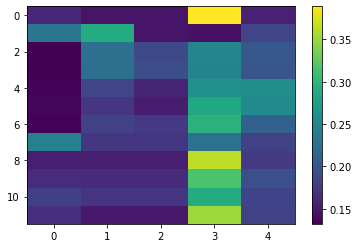

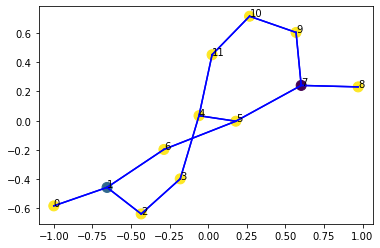

41


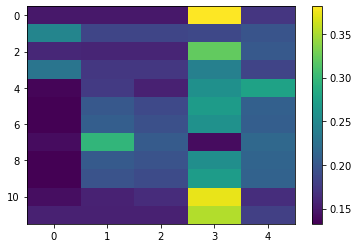

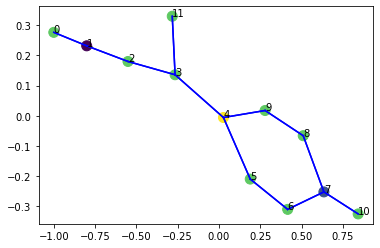

42


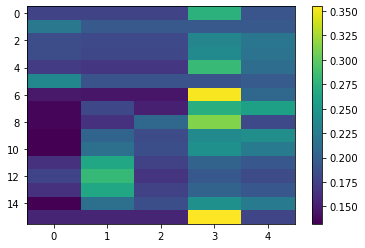

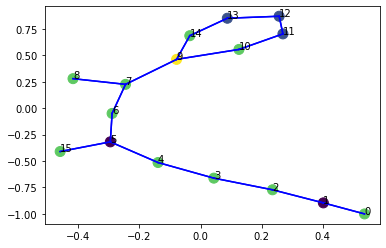

43


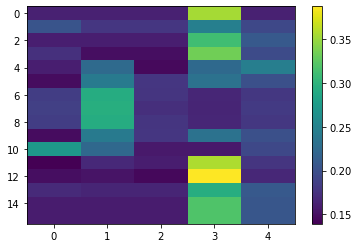

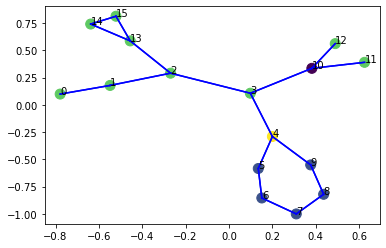

44


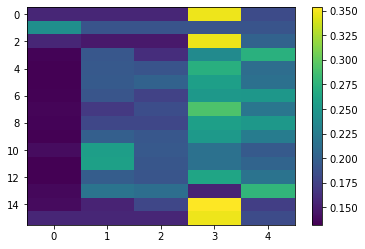

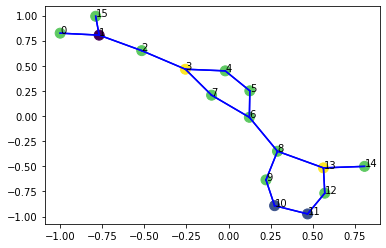

45


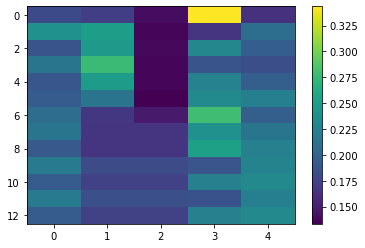

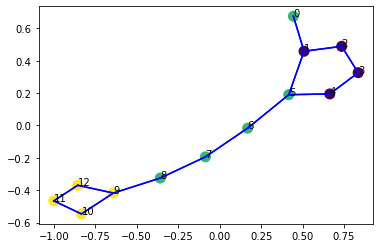

46


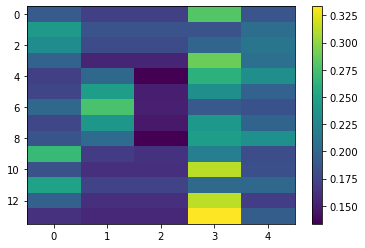

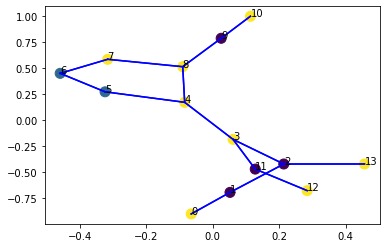

47


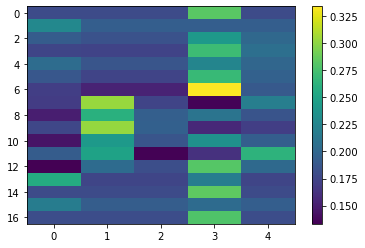

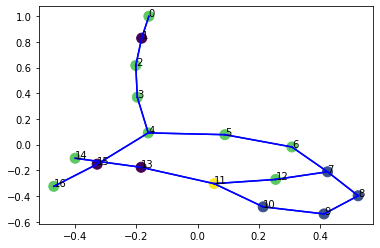

48


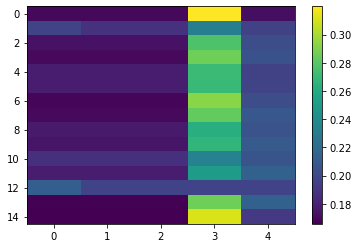

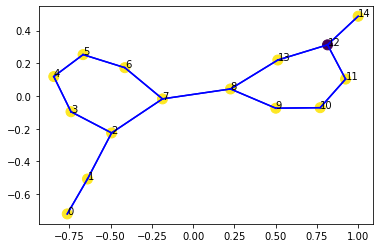

49


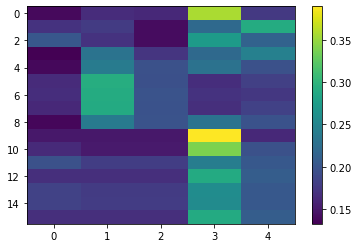

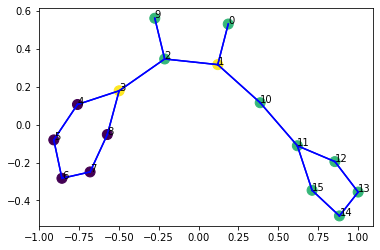

50


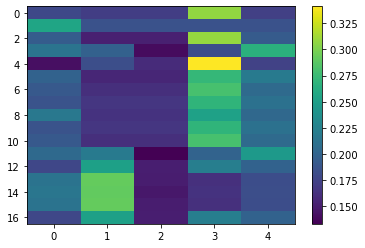

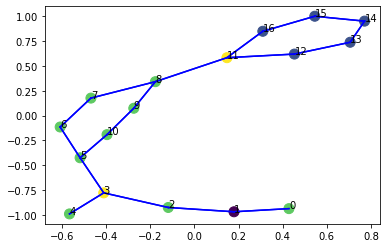

51


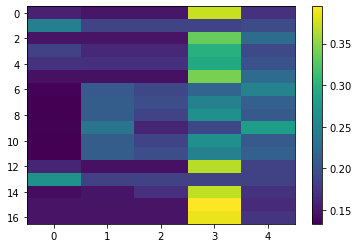

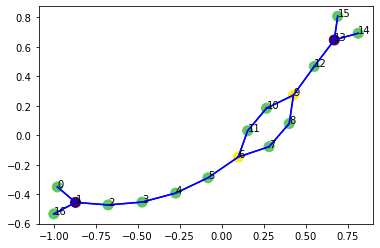

52


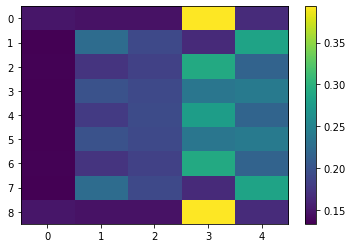

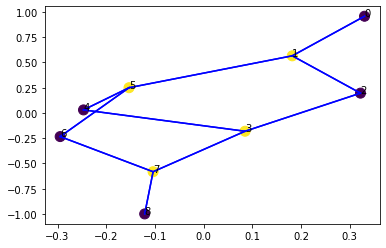

53


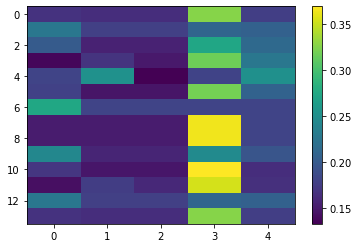

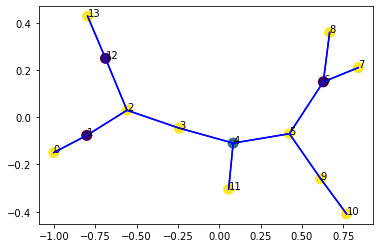

54


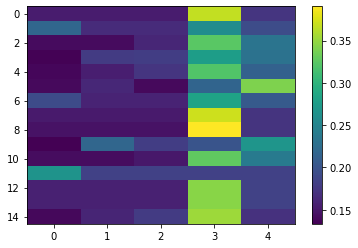

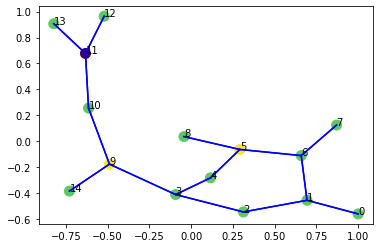

55


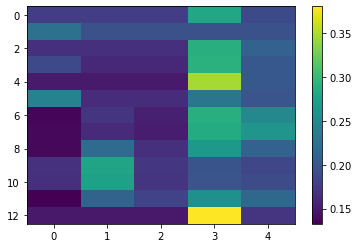

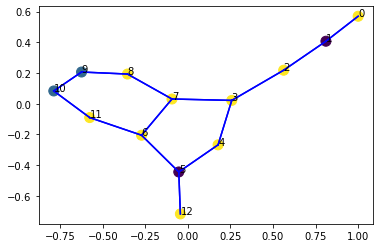

56


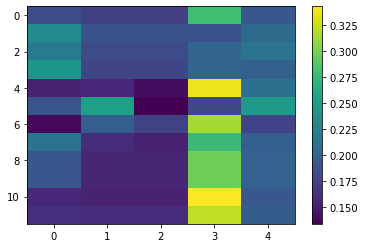

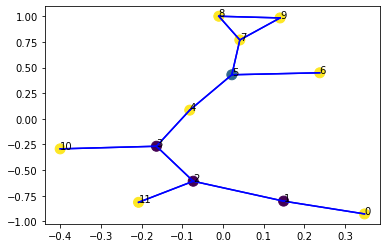

57


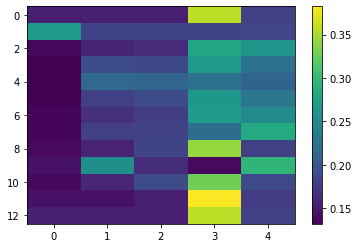

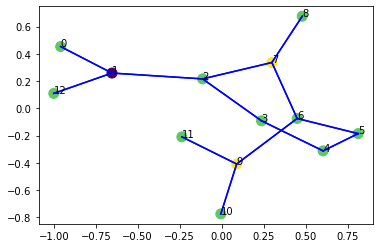

58


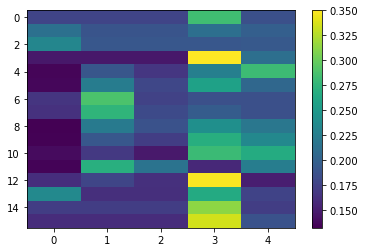

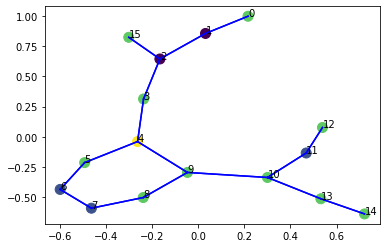

59


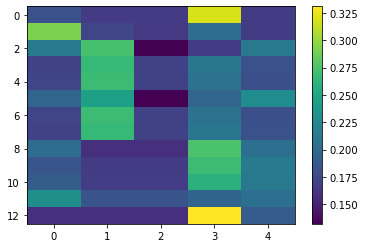

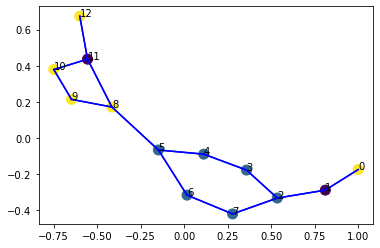

60


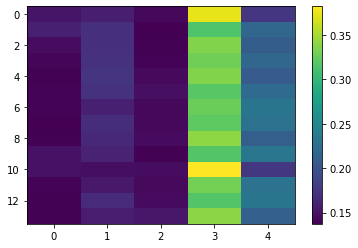

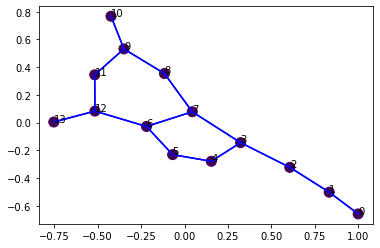

61


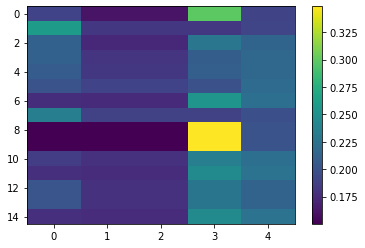

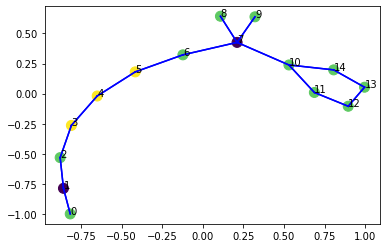

62


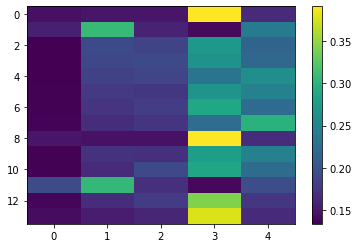

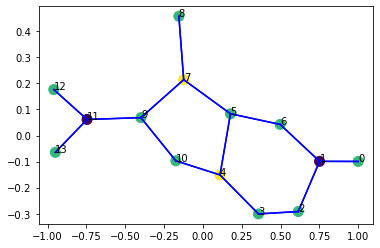

63


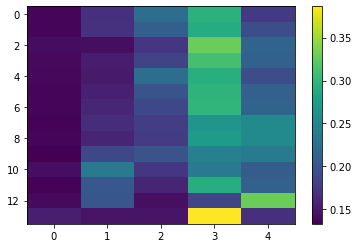

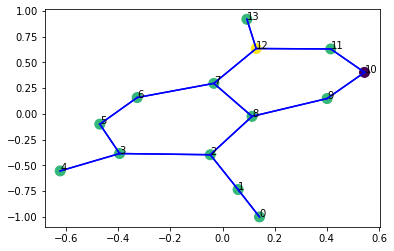

64


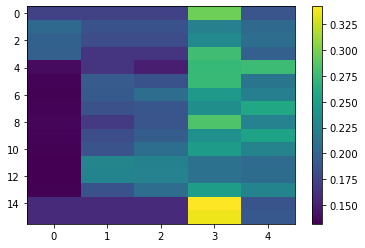

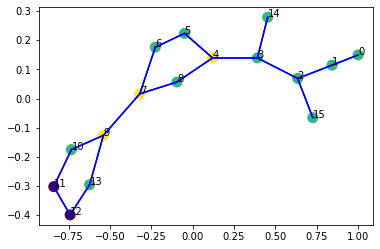

65


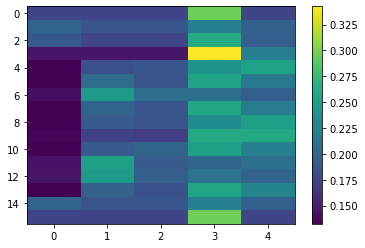

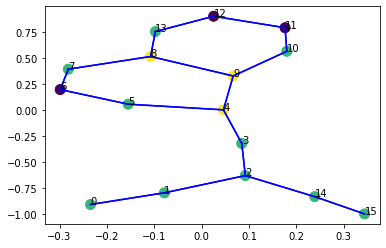

66


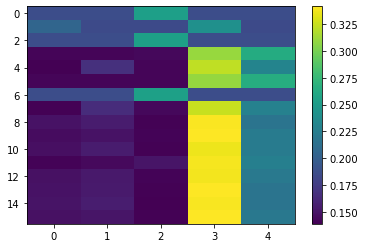

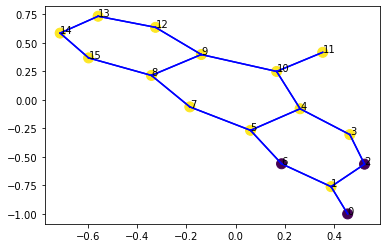

67


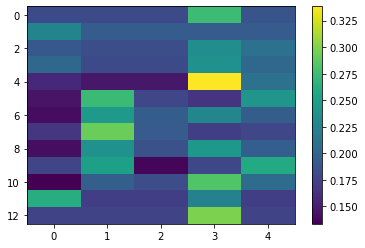

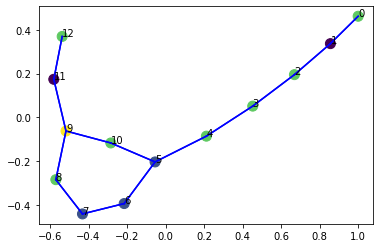

68


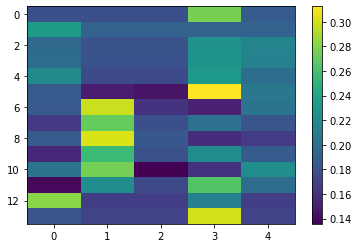

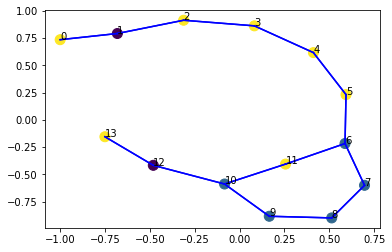

69


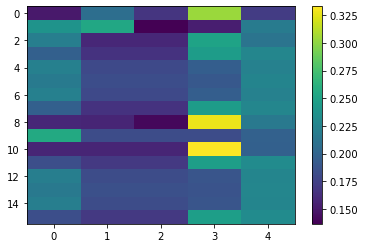

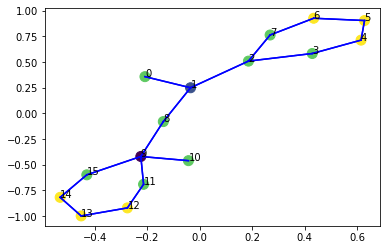

70


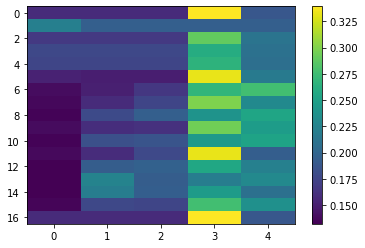

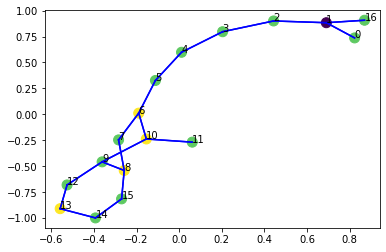

71


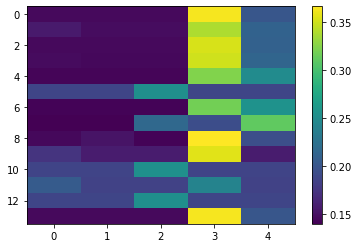

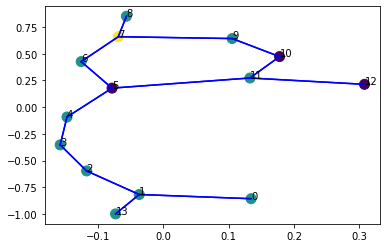

72


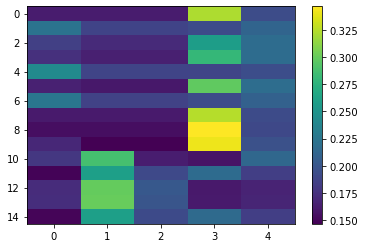

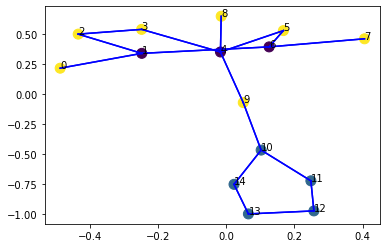

73


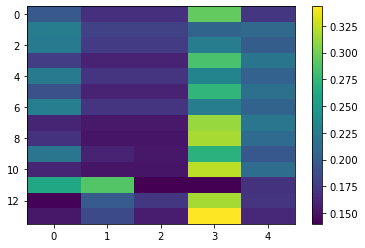

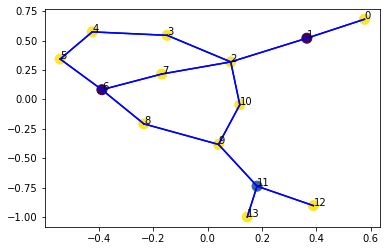

74


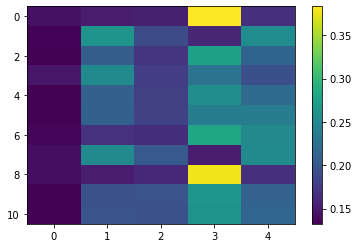

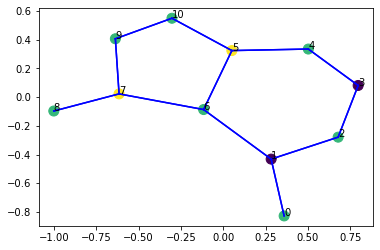

75


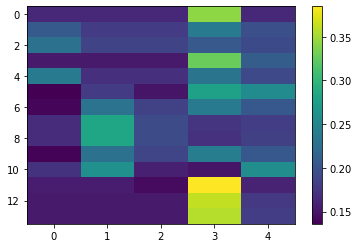

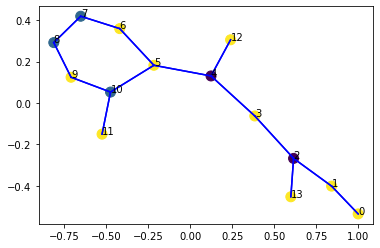

76


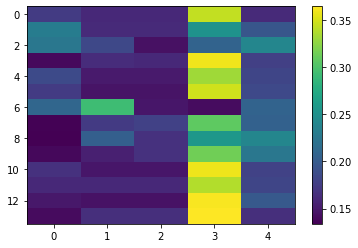

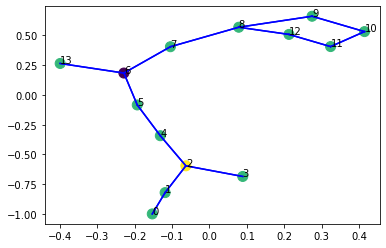

77


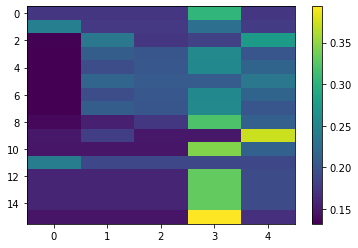

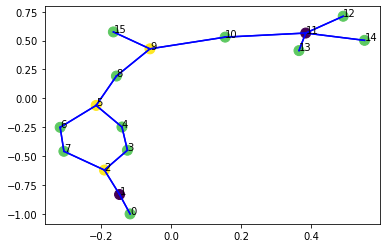

78


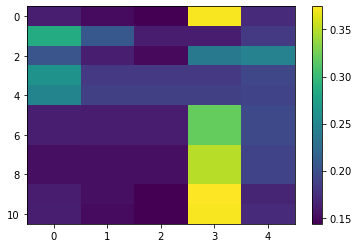

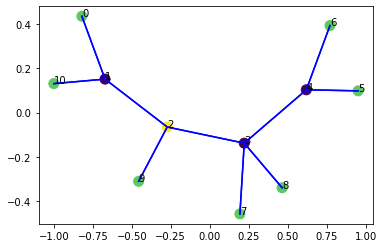

79


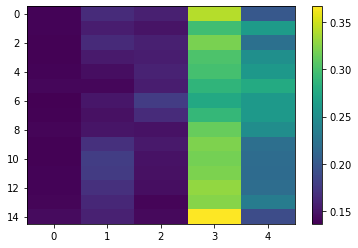

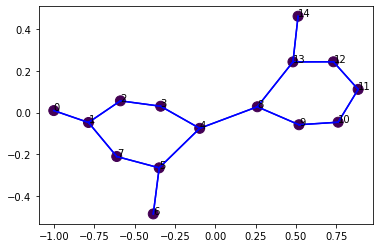

In [109]:
unbatchG = dgl.unbatch(g)

for i in range(len(assign_tensor)):
    print(i)
    mapping = assign_tensor[i].cpu().numpy()
    plt.imshow(mapping, aspect="auto")
    plt.colorbar()
    plt.show()
    
#     i = 106
#     A = unbatchG[i].adj(scipy_fmt='coo').toarray()
#     plt.imshow(A)
#     plt.show()

    G = unbatchG[i].cpu().to_networkx()
#     simpleG = nx.Graph()
#     simpleG.add_edges_from(list(G.edges()))
    
    maxColor = mapping.argmax(axis=1)

    pos = nx.spring_layout(G)

    posArr = np.array([x for _, x in pos.items()])
    maxColor = mapping.argmax(axis=1)

    fig, ax = plt.subplots()

    for edge in G.edges():
    #     print(edge)
        ax.plot([posArr[edge[0]][0], posArr[edge[1]][0]], [posArr[edge[0]][1], posArr[edge[1]][1]], 'b-')

    ax.scatter(posArr[:, 0], posArr[:, 1], c=maxColor, s=100)
    for txt, ij in pos.items():
        ax.annotate(txt, (ij[0], ij[1]))

    plt.show()
        
#     break

In [36]:
[x.shape for x in assign_tensor]

[torch.Size([12, 5]),
 torch.Size([10, 5]),
 torch.Size([7, 5]),
 torch.Size([15, 5]),
 torch.Size([12, 5]),
 torch.Size([14, 5]),
 torch.Size([16, 5]),
 torch.Size([11, 5]),
 torch.Size([18, 5]),
 torch.Size([16, 5]),
 torch.Size([15, 5]),
 torch.Size([16, 5]),
 torch.Size([17, 5]),
 torch.Size([14, 5]),
 torch.Size([7, 5]),
 torch.Size([12, 5]),
 torch.Size([14, 5]),
 torch.Size([14, 5]),
 torch.Size([13, 5]),
 torch.Size([16, 5]),
 torch.Size([12, 5]),
 torch.Size([16, 5]),
 torch.Size([12, 5]),
 torch.Size([13, 5]),
 torch.Size([17, 5]),
 torch.Size([16, 5]),
 torch.Size([17, 5]),
 torch.Size([14, 5]),
 torch.Size([14, 5]),
 torch.Size([13, 5]),
 torch.Size([12, 5]),
 torch.Size([17, 5]),
 torch.Size([15, 5]),
 torch.Size([15, 5]),
 torch.Size([15, 5]),
 torch.Size([12, 5]),
 torch.Size([7, 5]),
 torch.Size([10, 5]),
 torch.Size([8, 5]),
 torch.Size([17, 5]),
 torch.Size([12, 5]),
 torch.Size([12, 5]),
 torch.Size([16, 5]),
 torch.Size([16, 5]),
 torch.Size([16, 5]),
 torch.Size([1

In [37]:
adj.shape, h_node.shape

NameError: name 'adj' is not defined